# 03_Feature_Engineering_and_Modeling

PhD-level notebook: TF-IDF baselines + DistilBERT fine-tuning for IMDB sentiment classification.

Saves outputs (models, vectorizers, metrics) to the `results/` folder at project root.


In [1]:
%%bash
set -e
python -c "import sys; print('Python', sys.version)"
# Install datasets if missing (transformers assumed installed)
python -c "import importlib; importlib.import_module('datasets')" 2>/dev/null || pip install --quiet datasets


Python 3.12.4 (main, Jun  6 2024, 18:26:44) [Clang 15.0.0 (clang-1500.3.9.4)]


In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Paths (adjust if your project root differs)
PREPROCESSED_PATH = Path('/Users/ravina/Desktop/Text_Classification_Project/data/processed/imdb_preprocessed.csv')
RESULTS_DIR = Path('/Users/ravina/Desktop/Text_Classification_Project/results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print('Preprocessed path:', PREPROCESSED_PATH)
print('Results dir:', RESULTS_DIR)

assert PREPROCESSED_PATH.exists(), f'Preprocessed file not found at {PREPROCESSED_PATH}'
df = pd.read_csv(PREPROCESSED_PATH)
print('Loaded rows:', len(df))
df.head()


Preprocessed path: /Users/ravina/Desktop/Text_Classification_Project/data/processed/imdb_preprocessed.csv
Results dir: /Users/ravina/Desktop/Text_Classification_Project/results
Loaded rows: 50000


,review,sentiment,split,clean_text,processed_text
0,This movie is another Christian propaganda fil...,neg,train,this movie is another christian propaganda fil...,movie another christian propaganda film line o...
1,This show has been performed live around the c...,neg,test,this show has been performed live around the c...,show perform live around country wide variety ...
2,"Beast Wars is a show that is over-hyped, overp...",neg,train,beast wars is a show that is over hyped overpr...,beast war show hype overpraise overrate let me...
3,This is absolutely beyond question the worst m...,neg,test,this is absolutely beyond question the worst m...,absolutely beyond question bad movie ever see ...
4,A box with a button provides a couple with the...,neg,test,a box with a button provides a couple with the...,box button provide couple opportunity financia...


## Quick checks and train/test split
Ensure your dataframe contains a processed text column. The notebook will try `processed_text`, `final_review`, `clean_text`, then `review`.

In [3]:
# Choose text column
for col in ['processed_text','final_review','clean_text','review']:
    if col in df.columns:
        TEXT_COL = col
        break
print('Using text column:', TEXT_COL)

if df['sentiment'].dtype == 'object':
    df['sentiment'] = df['sentiment'].map({'neg':0,'pos':1})

X = df[TEXT_COL].astype(str)
y = df['sentiment'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train samples:', len(X_train), 'Test samples:', len(X_test))


Using text column: processed_text
Train samples: 40000 Test samples: 10000


## TF-IDF vectorization and Classical ML Baselines
We vectorize with TF-IDF and train Logistic Regression, MultinomialNB, LinearSVC, RandomForest.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import joblib


In [5]:
vec = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)
print('TF-IDF shape:', X_train_vec.shape)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC(max_iter=10000),
    'RandomForest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
}

TF-IDF shape: (40000, 10000)


In [6]:

results = {}
for name, model in models.items():
    print('\nTraining', name)
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    try:
        prob = model.predict_proba(X_test_vec)[:,1]
        auc = roc_auc_score(y_test, prob)
    except Exception:
        auc = None
    print(name, 'Accuracy:', acc, 'AUC:', auc)
    print(classification_report(y_test, preds))
    results[name] = {'model': model, 'accuracy': acc, 'auc': auc}
    joblib.dump(model, RESULTS_DIR / f'{name}.joblib')

# save vectorizer
joblib.dump(vec, RESULTS_DIR / 'tfidf_vectorizer.joblib')
print('\nSaved models and vectorizer to', RESULTS_DIR)



Training LogisticRegression
LogisticRegression Accuracy: 0.8978 AUC: 0.96256068
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Training MultinomialNB
MultinomialNB Accuracy: 0.8714 AUC: 0.9411068000000001
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5000
           1       0.86      0.89      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000


Training LinearSVC
LinearSVC Accuracy: 0.8913 AUC: None
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5000
           1       0

### Feature importance from Logistic Regression (top features)
We print top positive and negative coefficients from Logistic Regression for interpretability.

In [7]:
import numpy as np
clf = results['LogisticRegression']['model']
if hasattr(clf, 'coef_'):
    coefs = clf.coef_[0]
    top_pos_idx = np.argsort(coefs)[-30:][::-1]
    top_neg_idx = np.argsort(coefs)[:30]
    feature_names = np.array(vec.get_feature_names_out())
    print('Top positive features:')
    print(feature_names[top_pos_idx])
    print('\nTop negative features:')
    print(feature_names[top_neg_idx])
else:
    print('Model has no coef_')


Top positive features:
['great' 'excellent' 'perfect' 'amazing' 'wonderful' 'brilliant'
 'favorite' 'today' 'love' 'good' 'fun' 'enjoy' 'superb' 'hilarious'
 'enjoyable' 'must see' 'highly recommend' 'fantastic' 'one good'
 'well worth' 'entertaining' 'highly' 'gem' 'perfectly' 'well do' 'solid'
 'beautifully' 'definitely' 'incredible' 'wonderfully']

Top negative features:
['bad' 'waste' 'awful' 'poor' 'boring' 'terrible' 'nothing' 'dull' 'fail'
 'horrible' 'poorly' 'unfortunately' 'disappointment' 'suppose' 'stupid'
 'script' 'disappointed' 'disappointing' 'minute' 'lack' 'lame' 'instead'
 'save' 'ridiculous' 'annoying' 'waste time' 'pointless' 'sorry' 'cheap'
 'predictable']


In [8]:
import json
summary = {k: {'accuracy': v['accuracy'], 'auc': v['auc']} for k,v in results.items()}
with open(RESULTS_DIR / 'classical_results_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print('Saved classical results summary')


Saved classical results summary


In [9]:
summary

{'LogisticRegression': {'accuracy': 0.8978, 'auc': 0.96256068},
 'MultinomialNB': {'accuracy': 0.8714, 'auc': 0.9411068000000001},
 'LinearSVC': {'accuracy': 0.8913, 'auc': None},
 'RandomForest': {'accuracy': 0.8563, 'auc': 0.931542}}

## DistilBERT Fine-tuning (Hugging Face)
This section fine-tunes DistilBERT. **Warning:** fine-tuning on CPU is slow. For research, use GPU. We run 1 epoch here for a quick experiment.

In [10]:
import torch
import transformers
import datasets
import evaluate

print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.8.0
Transformers: 4.57.0
Datasets: 4.1.1
CUDA available: False


In [11]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

In [12]:
# Build HF Datasets
train_df = pd.DataFrame({'text': X_train.values, 'label': y_train.values})
test_df = pd.DataFrame({'text': X_test.values, 'label': y_test.values})
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=256)

train_ds = train_ds.map(tokenize_function, batched=True)
train_ds = train_ds.remove_columns(['text'])
train_ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])

test_ds = test_ds.map(tokenize_function, batched=True)
test_ds = test_ds.remove_columns(['text'])
test_ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
! pip install -U transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 2.9 MB/s  0:00:04 eta 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.2
    Uninstalling transformers-4.56.2:
      Successfully uninstalled transformers-4.56.2
Note: you may need to restart the kernel to use updated packages.


In [13]:
import transformers
print(transformers.__version__)


4.57.0


In [17]:
import sys
print(sys.executable)

/Users/ravina/Desktop/text_classification_project/venv/bin/python


In [15]:
from transformers import AutoModelForSequenceClassification, TrainingArguments
from pathlib import Path

RESULTS_DIR = Path("results")

model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=str(RESULTS_DIR / 'hf_outputs'),
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',   # ✅ fixed keyword
    save_strategy='no',
    logging_steps=100,
    fp16=False,
)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/var/folders/3t/5qtlv2451k3fkqv9ls22lmg00000gn/T/ipykernel_72238/1265177924.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
# Train (may be slow on CPU)
trainer.train()

# Evaluate and save
metrics = trainer.evaluate()
print('DistilBERT eval metrics:', metrics)
trainer.save_model(RESULTS_DIR / 'hf_outputs' / 'distilbert_imdb')
print('Saved DistilBERT to', RESULTS_DIR / 'hf_outputs' / 'distilbert_imdb')

/Users/ravina/Desktop/text_classification_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.250300,0.276019,0.899000,0.895676,0.903200,0.899422


/Users/ravina/Desktop/text_classification_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


DistilBERT eval metrics: {'eval_loss': 0.276019424200058, 'eval_accuracy': 0.899, 'eval_precision': 0.895676318921063, 'eval_recall': 0.9032, 'eval_f1': 0.8994224258115913, 'eval_runtime': 1649.3018, 'eval_samples_per_second': 6.063, 'eval_steps_per_second': 0.379, 'epoch': 1.0}
Saved DistilBERT to results/hf_outputs/distilbert_imdb


## Comparison & Next Steps
- Compare classical results (saved in `results/classical_results_summary.json`) with DistilBERT metrics printed above.
- For full transformer training, use a GPU (Colab or cloud). Consider distillation for production.

Files saved to `results/`:
- TF-IDF vectorizer: `results/tfidf_vectorizer.joblib`
- Classical models: `results/{model}.joblib`
- Classical summary: `results/classical_results_summary.json`
- DistilBERT outputs: `results/hf_outputs/distilbert_imdb`


## already we saw metrics like accuracy, precision, recall, and F1.
### But to deeply understand model behavior we will:
1. Plot confusion matrix to see which classes are being confused.
2. Inspect misclassified examples — these tell you where the model struggles.


/Users/ravina/Desktop/text_classification_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


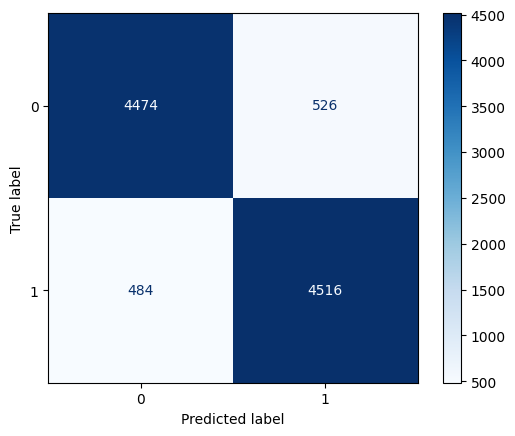

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()


## Let's Run Predictions on Custom Texts
testing our trained model on our own sentences:

In [22]:
import torch

text = "This movie was absolutely fantastic, I loved every bit!"
inputs = tokenizer(text, return_tensors="pt")

# Force CPU
model.to("cpu")
inputs = {k: v.to("cpu") for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
pred = outputs.logits.argmax().item()

print("Predicted label:", pred)


Predicted label: 1


In [25]:
from datasets import load_dataset, ClassLabel

# Suppose you already have train_ds and test_ds
train_ds = train_ds.cast_column(
    "label", ClassLabel(num_classes=2, names=["negative", "positive"])
)
test_ds = test_ds.cast_column(
    "label", ClassLabel(num_classes=2, names=["negative", "positive"])
)


Casting the dataset:   0%|          | 0/40000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [26]:
#create a small helper:

def classify_text(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    pred = outputs.logits.argmax().item()
    label = train_ds.features['label'].int2str(pred)
    return label


In [28]:
classify_text("This film is a masterpiece!")


'positive'

In [29]:
classify_text("The plot was boring and predictable.")


'negative'

## Save the Model & Tokenizer


In [30]:
save_dir = "results/final_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


('results/final_model/tokenizer_config.json',
 'results/final_model/special_tokens_map.json',
 'results/final_model/vocab.txt',
 'results/final_model/added_tokens.json',
 'results/final_model/tokenizer.json')

## To reload later:

In [31]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained(save_dir)
tokenizer = AutoTokenizer.from_pretrained(save_dir)
